In [1]:
from __future__ import print_function, absolute_import, division

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt

In [4]:
# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

In [5]:
# For loading NIfTI
import nibabel as nib

In [6]:
# Load the FMRI data
img = nib.load('ds114_sub009_t2r1.nii')
data = img.get_data()
data.shape

(64, 64, 30, 173)

In [7]:
# Knock off first four scans
n_dummies = 4
data = data[..., n_dummies:]
n_scans = data.shape[-1]

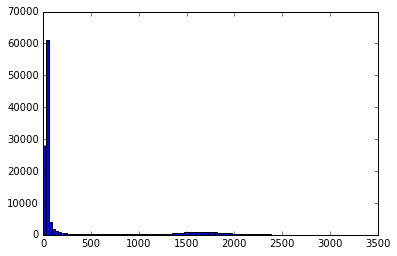

In [8]:
# Use mean image to extract brain
mean_data = data.mean(axis=-1)
_ = plt.hist(np.ravel(mean_data), bins=100)

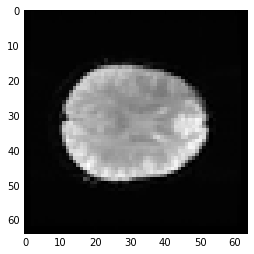

In [9]:
plt.imshow(mean_data[:, :, 15])

In [10]:
# Extract mask with hand-crafted value
mask = mean_data > 900

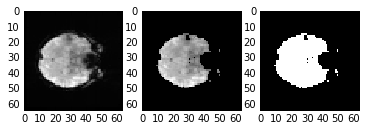

In [11]:
# Show example brain slices
slice_no = 7
fig, axes = plt.subplots(1, 3)
axes[0].imshow(mean_data[:, :, slice_no])
axes[1].imshow((mean_data * mask)[:, :, slice_no])
axes[2].imshow(mask[:, :, slice_no])

In [12]:
# Get in-brain time courses
vox_by_time = data[mask]
vox_by_time.shape

(21353, 169)

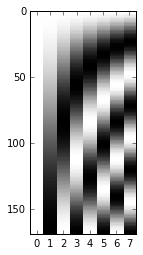

In [13]:
# Make discrete cosine basis set
# See https://en.wikipedia.org/wiki/Discrete_cosine_transform#DCT-II
N = n_scans
n = np.arange(n_scans)
n_plus_half = n + 0.5
dct_basis = np.ones((N, 8))
for k in range(0, 8):
    dct_basis[:, k] = np.cos(np.pi / N * n_plus_half * k)
plt.imshow(dct_basis, aspect=0.1)

In [14]:
# Project out the the DCT basis
time_by_vox = vox_by_time.T
B_dct = spl.pinv(dct_basis).dot(time_by_vox)
filtered_t_v = time_by_vox - dct_basis.dot(B_dct)

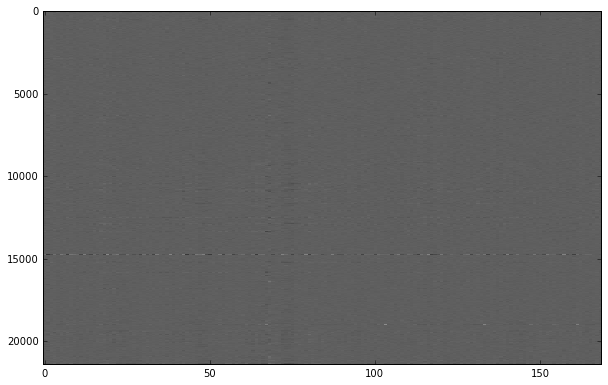

In [16]:
# Do plot similar to Power et al 2013
plt.figure(figsize=(10, 25))
plt.imshow(filtered_t_v.T, aspect=0.005)

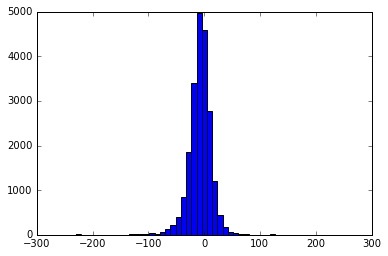

In [17]:
# Plot histogram of all voxel values for first volume
_ = plt.hist(filtered_t_v[0, :], bins=50)

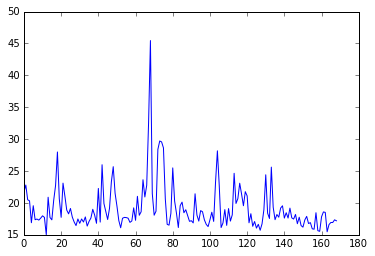

In [18]:
# Are there systematic dips or peaks in variance, shared across voxels?
rms_over_voxels = np.sqrt((filtered_t_v.T ** 2).mean(axis=0))
plt.plot(rms_over_voxels)

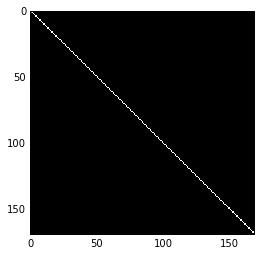

In [19]:
# Make a design matrix with deltas for each scan
X_delta = np.eye(n_scans)
plt.imshow(X_delta)

From Wikipedia: https://en.wikipedia.org/wiki/Spin%E2%80%93lattice_relaxation

$$
M_z(t) = M_{z,\mathrm{eq}} - \left [ M_{z,\mathrm{eq}} - M_{z}(0) \right ] e^{-t/T_1}
$$

In [21]:
t1_gray_3t = 1.3  # Seconds. Wansapura et al. JMRI 9: 531-538 (1999)
t1_gray_1p5t = 0.920  # Seconds. https://en.wikipedia.org/wiki/Relaxation_(NMR)#T1

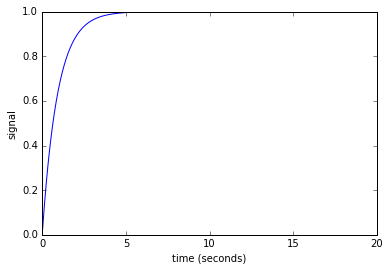

In [22]:
# Plot the T1 effect
Mz_0 = 0
Mz_eq = 1
t = np.linspace(0, 20, 1000)
t1_signal = Mz_eq - (Mz_eq - Mz_0) * np.e ** (-t / t1_gray_1p5t)
plt.plot(t, t1_signal)
plt.xlabel('time (seconds)')
plt.ylabel('signal')

In [23]:
TR = img.header['pixdim'][4]  # Sometimes this is not set correctly
TR

2.5

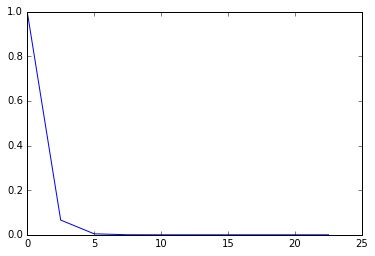

In [24]:
# Make a T1 decay regressor starting at the first scan
t = np.arange(n_scans) * TR
t1_relaxation = np.e ** (-t / t1_gray_1p5t)
plt.plot(t[:10], t1_relaxation[:10])

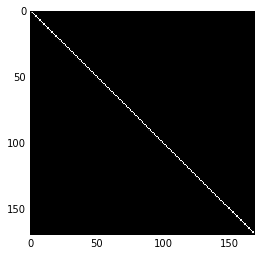

In [25]:
# Make a regressor matrix with this kernel in each column, offset
X_t1 = spl.toeplitz(t1_relaxation, np.zeros(n_scans))
plt.imshow(X_t1)

In [27]:
# Project onto this basis to look for outlier scans
B_t1 = X_t1.T.dot(filtered_t_v)

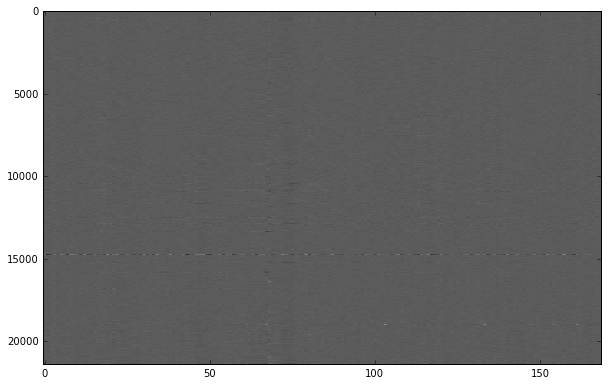

In [28]:
plt.figure(figsize=(10, 25))
plt.imshow(B_t1.T, aspect=0.005)

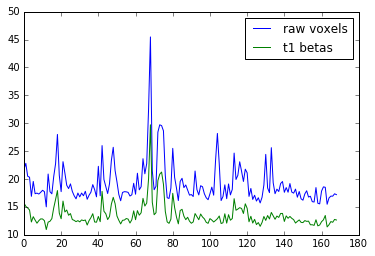

In [29]:
# Are there systematic dips or peaks in these betas across voxels?
rms_over_t1_betas = np.sqrt(B_t1.T ** 2).mean(axis=0)
plt.plot(rms_over_voxels, label='raw voxels')
plt.plot(rms_over_t1_betas, label='t1 betas')
plt.legend()

Make the experimental design

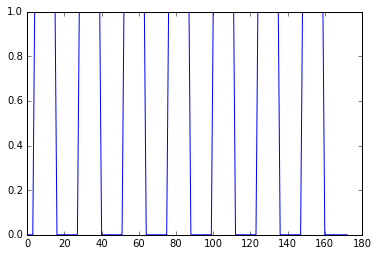

In [30]:
from stimuli import events2neural
neural = events2neural('ds114_sub009_t2r1_cond.txt', TR, img.shape[-1])
plt.plot(neural)

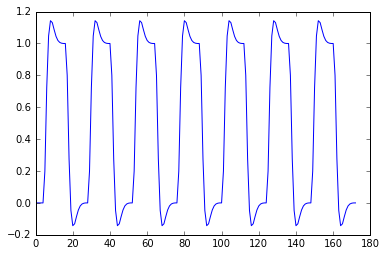

In [31]:
# Convolve with HRF
from spm_funcs import spm_hrf
hrf_times = np.arange(0, 30, TR)
hrf_samples = spm_hrf(hrf_times)
hemo = np.convolve(neural, hrf_samples)[:len(neural)]
plt.plot(hemo)

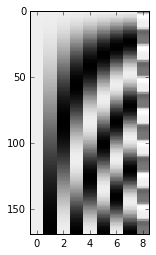

In [32]:
# Knock off dummy scans, compile design
X_e = np.hstack((dct_basis, hemo[n_dummies:, None]))
plt.imshow(X_e, aspect=1/10.)

In [33]:
# Make regreg problem
design = X_e
Y = time_by_vox
X = np.hstack((X_delta, X_t1))
n_tr, n_vox = Y.shape
n_basis = X.shape[1]
n_tr, n_vox, n_basis

(169, 21353, 338)

In [34]:
import regreg.api as rr

In [35]:
design_pinv = np.linalg.pinv(design)
# Projector onto space of experimental design
P_design = np.dot(design, design_pinv)
# Residual-forming matrix
R_design = np.eye(n_tr) - P_design
# Residuals of data w.r.t design
resid_design = np.dot(R_design, Y)

# X matrix for problem should be residualized w.r.t. design as well 
# -- important
X_ort_design = np.dot(R_design, X)

loss_resid = rr.squared_error(X_ort_design, resid_design)
loss_resid.shape = (n_basis, n_vox)
loss_resid

affine_smooth(quadratic((169,), coef=1, Q=None, Qdiag=False, offset=[[ -1.32363776   3.48115434 -44.57658213 ...,  -8.43813835 -23.79872852
   -6.35979545]
 [  2.85987809   9.39313331 -30.11974225 ..., -30.33784745 -37.79379938
  -26.80326187]
 [  0.9597857   -6.82214392  11.04402434 ...,   7.53732928  12.50782969
    4.65022283]
 ..., 
 [ -5.76125566 -19.90269318  14.97257136 ...,   8.30376192   9.48485253
    6.0527198 ]
 [-20.75115078 -14.98127671 -21.84342779 ...,  15.42850614  17.60386948
   22.22406593]
 [ -0.75091198  26.97947605   8.24754002 ...,  22.48665334   7.66880385
    7.30790964]]), <regreg.affine.linear_transform object at 0x12adfc310>, store_grad=True)

In [36]:
penalty = rr.l1_l2(loss_resid.shape, lagrange=1.)
penalty.shape

(338, 21353)

In [37]:
dual_penalty = penalty.conjugate
lam_max = dual_penalty.seminorm(
    loss_resid.smooth_objective(np.zeros(loss_resid.shape), 'grad'),
    lagrange=1)
lam_max

6735.1056323805415

In [38]:
penalty.lagrange = 0.9 * lam_max

In [39]:
# Residual problem after orthogonalizing w.r.t experimental design
problem_resid = rr.simple_problem(loss_resid, penalty)
problem_resid

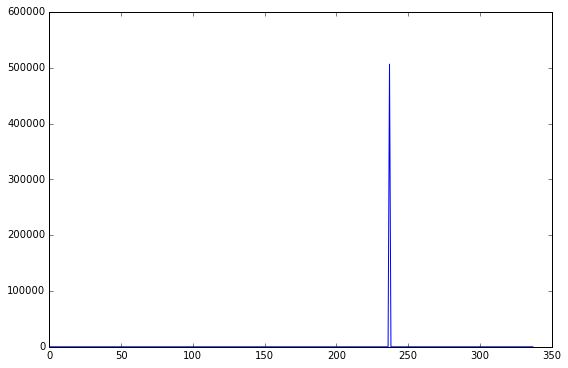

In [40]:
soln_resid = problem_resid.solve(min_its=200, tol=1.e-12)
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
ax.plot((soln_resid**2).sum(1))

In [42]:
# Reconstructing estimates for experimental design
coefs_resid = np.dot(design_pinv, Y - np.dot(X, soln_resid))
coefs_resid.shape

(9, 21353)

In [44]:
# Coefficients without sparse part
coefs = design_pinv.dot(Y)
coefs.shape

(9, 21353)

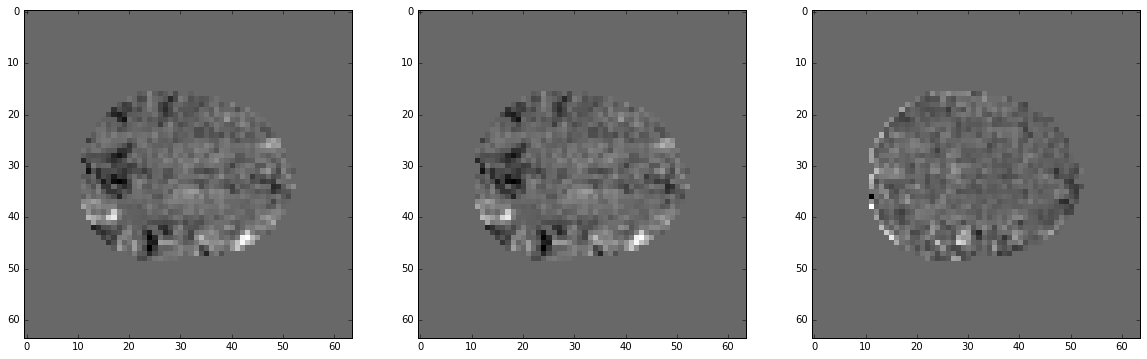

In [56]:
task_resid = np.zeros(mean_data.shape)
task = np.zeros(mean_data.shape)
task_resid[mask] = coefs_resid[-1, :]
task[mask] = coefs[-1, :]
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(task_resid[:, :, 14])
axes[1].imshow(task[:, :, 14])
axes[2].imshow((task - task_resid)[:, :, 14])

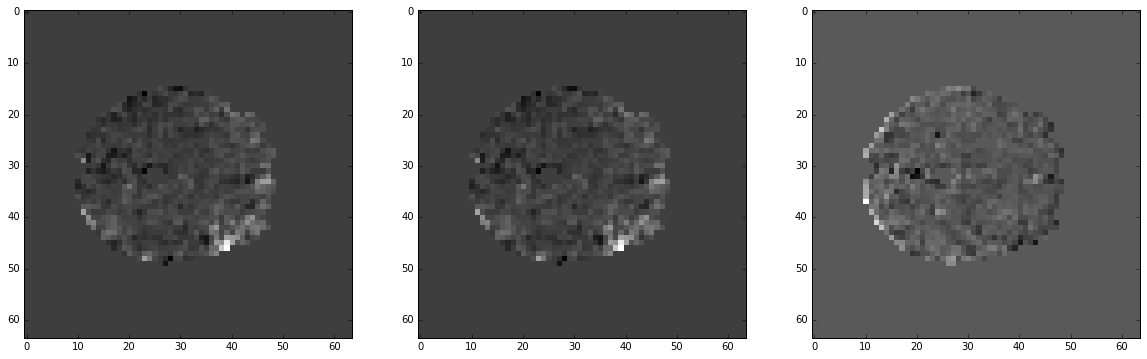

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(task_resid[:, :, 10])
axes[1].imshow(task[:, :, 10])
axes[2].imshow((task - task_resid)[:, :, 10])